In [1]:
import h5py
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
import scipy
import time

from os import listdir
from os.path import isfile, join

import matplotlib
from matplotlib import pyplot as plt

import bacco
import bacco.probabilistic_bias as pb

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../code')
import utils
import plotter

2024-08-19 12:06:19.449205: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-19 12:06:22.122096: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-19 12:06:22.129625: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 12:07:00.660542: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-19 12:07:40.974718: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

In [2]:
matplotlib.pyplot.style.use('default')
matplotlib.pyplot.close('all')

matplotlib.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams['xtick.labelsize'] = 16 
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 20
matplotlib.rcParams['lines.linewidth'] = 2

In [3]:
def get_volume_Mpc(box_size, h, fn_dat):
    TotTreeFiles = 512
    matches = re.search(r"tree(\d+)-(\d+)", fn_dat)
    ft, lt = int(matches.group(1)), int(matches.group(2))
    #numbers = re.findall(r'\d+', tag_trees)
    #ft, lt = int(numbers[0]), int(numbers[1])
    TreeFilesUsed_thisfile = lt - ft +1
    vol_Mpch_thisfile = box_size**3 * TreeFilesUsed_thisfile / TotTreeFiles
    vol_Mpc_thisfile = vol_Mpch_thisfile / h**3 # X Mpc/h * (h/0.7) = X/0.7 Mpc
    return vol_Mpc_thisfile

In [4]:
## TODO figure out which to be using!! 

## "NEW COSMOLOGY"
box_size = 480.279
omega_matter = 0.315
baryon_fraction = 0.155
omega_baryon = omega_matter * baryon_fraction
omega_cdm = omega_matter - omega_baryon
mill_planck_dict = {'omega_baryon': omega_baryon, #omega_m * baryon_fraction
             'omega_de': 0.685,
             'hubble': 0.673,
             'omega_cdm': omega_cdm,
             }
cosmo = bacco.Cosmology(verbose=False, **mill_planck_dict)

## ORIGINAL MILLENNIUM
#box_size = 500.
#cosmo = bacco.Cosmology(verbose=False, **bacco.cosmo_parameters.Millennium)

print(cosmo.pars)
h = cosmo.pars['hubble']

{'hubble': 0.673, 'sigma8': 0.9, 'A_s': None, 'omega_baryon': 0.048825, 'omega_cdm': 0.266175, 'w0': -1, 'wa': 0, 'ns': 0.9611, 'tau': 0.0952, 'approx_nu': False, 'num_massive_neutrinos': 0, 'neutrino_mass': 0.0, 'Neffective': 3.046, 'DeltaNeff': 3.046, 'GammaNu': 0.71611, 'omega_neutrino': 0.0, 'omega_matter': 0.315, 'omega_cold': 0.315, 'photon_temperature': 2.7255, 'omega_photons': 0.0, 'omega_rad': 0.0, 'omega_k': 0.0, 'omega_de': 0.685, 'omega_tot': 1.0}


In [5]:
dir_base = '/dipc/kstoreyf/external/LGalaxies2020_PublicRepository'
dir_base_input = '/dipc/kstoreyf/external/LGalaxaies2020_PublicRepository/input'
model = 'default' #'default'

tag_params = '_AgnEfficiency_n10'
tag_lgal = f'_DM_fasttesting{tag_params}'
tag_trees = '_tree0-15'
iparam_start = 0
iparam_end = 9
iparams = np.arange(iparam_start, iparam_end+1)

In [6]:
fn_arr = []
gal_arr = []
smf_arr = []

for iparam in iparams:
       
    version = f'iparam{iparam}'
    dir_out = f'{dir_base}/output/output{tag_lgal}/samples'
    fn_out = f'{dir_out}/Planck_Mil-I_snapshots_{model}_{version}_z0.00-0.00_All{tag_trees}.npy'
    print(fn_out)
    
    gals = np.load(fn_out)
    
    log_mstar = np.log10(gals['StellarMass'])
    vol_Mpc_thisfile = get_volume_Mpc(box_size, h, tag_trees)
    bins_log_mstar, smf = utils.compute_smf(log_mstar, vol_Mpc_thisfile)
    
    fn_arr.append(fn_out)    
    gal_arr.append(gals)
    smf_arr.append(smf)

/dipc/kstoreyf/external/LGalaxies2020_PublicRepository/output/output_DM_fasttesting_AgnEfficiency_n10/samples/Planck_Mil-I_snapshots_default_iparam0_z0.00-0.00_All_tree0-15.npy
/dipc/kstoreyf/external/LGalaxies2020_PublicRepository/output/output_DM_fasttesting_AgnEfficiency_n10/samples/Planck_Mil-I_snapshots_default_iparam1_z0.00-0.00_All_tree0-15.npy
/dipc/kstoreyf/external/LGalaxies2020_PublicRepository/output/output_DM_fasttesting_AgnEfficiency_n10/samples/Planck_Mil-I_snapshots_default_iparam2_z0.00-0.00_All_tree0-15.npy
/dipc/kstoreyf/external/LGalaxies2020_PublicRepository/output/output_DM_fasttesting_AgnEfficiency_n10/samples/Planck_Mil-I_snapshots_default_iparam3_z0.00-0.00_All_tree0-15.npy
/dipc/kstoreyf/external/LGalaxies2020_PublicRepository/output/output_DM_fasttesting_AgnEfficiency_n10/samples/Planck_Mil-I_snapshots_default_iparam4_z0.00-0.00_All_tree0-15.npy
/dipc/kstoreyf/external/LGalaxies2020_PublicRepository/output/output_DM_fasttesting_AgnEfficiency_n10/samples/Planc

In [7]:
param_df = pd.read_csv(f'../data/params_lgal/params_lgal{tag_params}.txt', index_col=0)

In [8]:
# probabilistic SMF
# in Mpc^-3 (no h factor!!)
fn_psmf_bgs = '../data/psmf.sv3.bgs_bright.z0.01_0.05.dat'
ms, psmf_bgs_mean, psmf_bgs_std = np.loadtxt(fn_psmf_bgs, unpack=True)

In [9]:
param_df.loc[0]['AgnEfficiency']

1e-08

In [10]:
len(smf_arr)

10

/tmp/ipykernel_391008/2697757918.py:29: RuntimeWarning: invalid value encountered in divide
  ax1.plot(bins_log_mstar, (smf_arr[i]-smf_fid)/smf_fid, lw=2, color=colors[i],


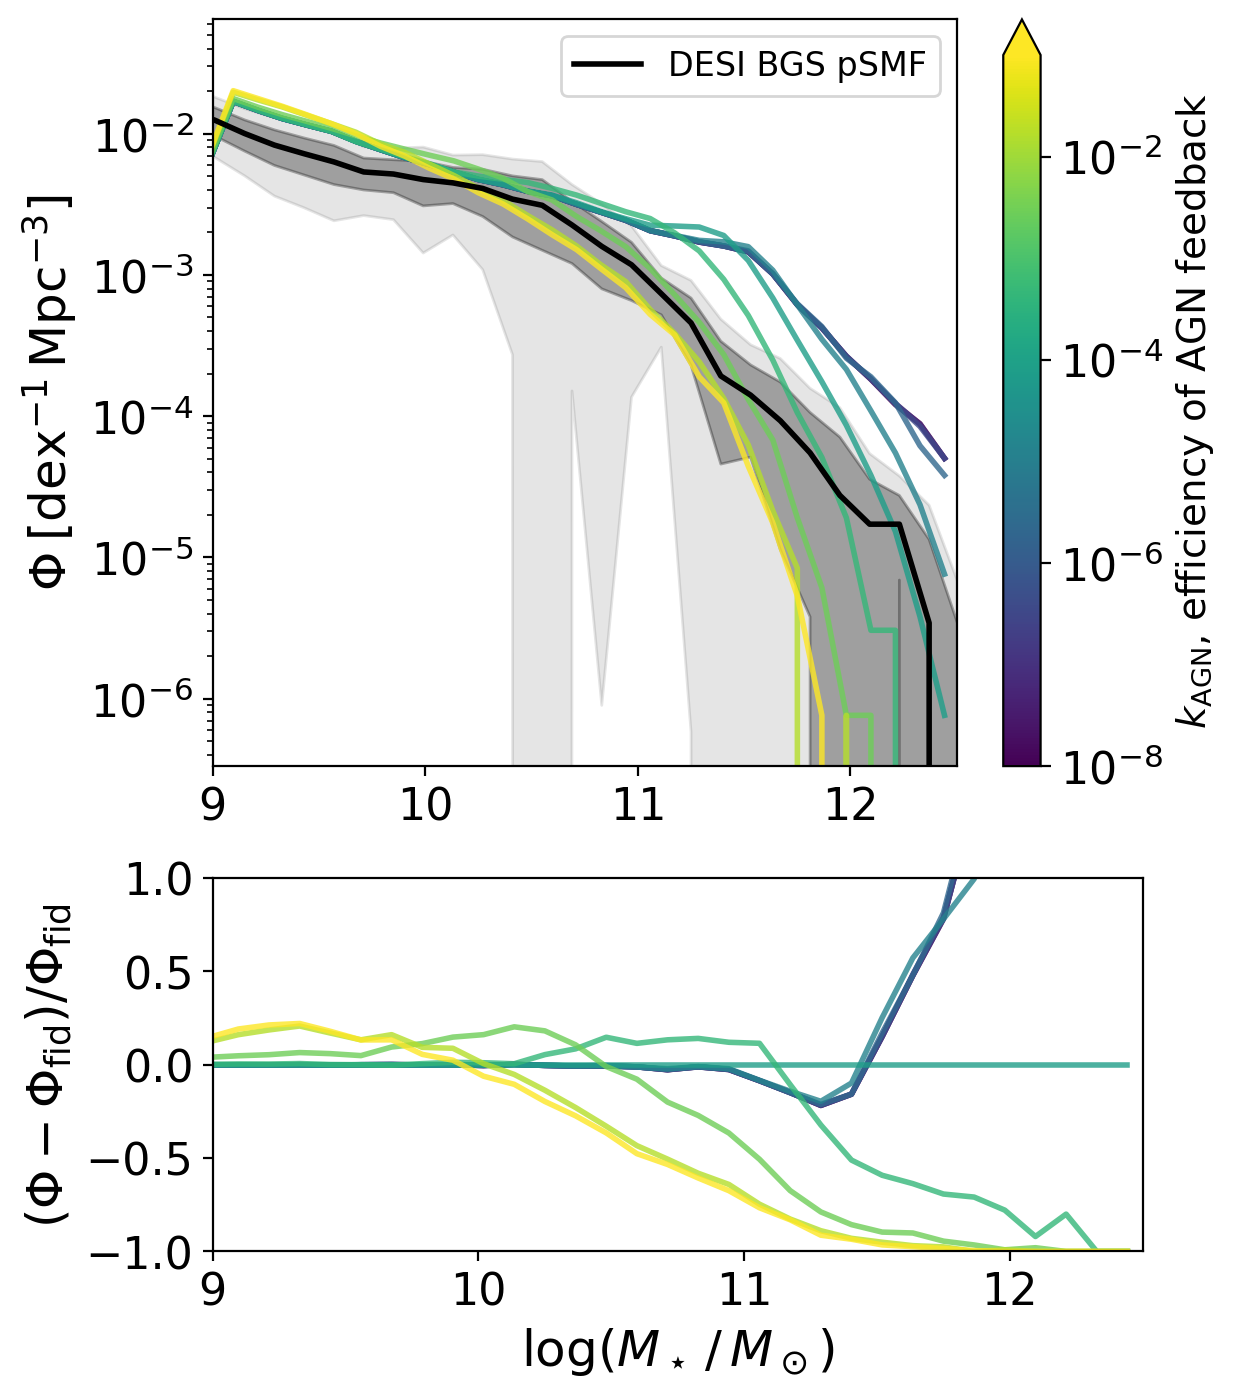

In [11]:
rng = np.random.default_rng()
#colors = ['black']*len(smf_arr)
#color_mode = None
color_mode = 'continuous'
param_colorby = param_df.columns[0]
vals_colorby = [param_df.loc[iparam][param_colorby] for iparam in iparams]
colors, cmap, locs_norm = utils.get_colors(vals_colorby, log=True)
#lss = ['-', '--', '-.', ':', '-', '--', '-.', ':']
lss = ['-']*len(iparams)
 
fig, axarr = plt.subplots(2, 1, figsize=(6, 8), #sharex=True,
                          height_ratios=[2, 1])
ax, ax1 = axarr
 
i_fid = 5
smf_fid = smf_arr[i_fid]

for i, iparam in enumerate(iparams):
    # if i==0:
    #     label='L-Galaxies SMF'
    # else:
    #     label=None
    #label = tags_trees[i][1:]
    label = None
    ax.plot(bins_log_mstar, smf_arr[i], lw=2, color=colors[i], 
             ls=lss[i],
             alpha=0.8, label=label)
    
    ax1.plot(bins_log_mstar, (smf_arr[i]-smf_fid)/smf_fid, lw=2, color=colors[i], 
            ls=lss[i],
            alpha=0.8, label=label)
    
if color_mode=='continuous':
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
    cb = plt.colorbar(sm, ax=ax, extend='max')
    cbar_label = r'$k_\text{AGN}$, efficiency of AGN feedback'
    cb.set_label(label=cbar_label, size=14)
        

ax.plot(ms, psmf_bgs_mean, color='black', label=r'DESI BGS pSMF')
ax.fill_between(ms, 
                 psmf_bgs_mean-psmf_bgs_std, 
                 psmf_bgs_mean+psmf_bgs_std,
                 color='black', alpha=0.3,
                 )
ax.fill_between(ms, 
                 psmf_bgs_mean-2*psmf_bgs_std, 
                 psmf_bgs_mean+2*psmf_bgs_std,
                 color='black', alpha=0.1,
                 )

# plt.errorbar(m13ksf_log_m_msun, m13ksf_phi_Mpcn3, yerr=m13ksf_err, color='blue', marker='o', 
#              alpha=0.5, markersize=4, ls='None', #facecolor='None', s=8,
#              label='SDSS/PRIMUS \n(Moustakas+2013)')
    
ax.set_xlim(9, 12.5)
ax1.set_xlim(9, 12.5)
ax1.set_ylim(-1, 1)

ax.set_yscale('log')
ax1.set_xlabel(r'$\log(M_\star\,/\,M_\odot)$')
ax.set_ylabel(r'$\Phi \: [\mathrm{dex}^{-1}\, \mathrm{Mpc}^{-3}]$')
ax1.set_ylabel(r'$(\Phi-\Phi_\text{fid})/\Phi_\text{fid}$')
ax.set_xlim(9, 12.5)

handles, labels = ax.get_legend_handles_labels()
if color_mode=='discrete':
    handles.extend(handles_discrete)
ax.legend(handles=handles, fontsize=12)



### Measure bias params

In [12]:
n_grid = 512 #??
# believe LPT order is 1 (ZA); see Springel 2005 (https://arxiv.org/pdf/astro-ph/0505010)
# which cites Heitmann 2004 (https://arxiv.org/pdf/astro-ph/0411795, S5.1)
LPT_order = 1 
# TODO changing LPT_order doesn't seem to be doing anything, CHECK
seed_millennium = 100672

sim = bacco.utils.create_lpt_simulation(cosmo, box_size, Nmesh=n_grid, 
                                        Seed=seed_millennium,
                                        FixedInitialAmplitude=False, InitialPhase=0, 
                                        expfactor=1.0, LPT_order=LPT_order, order_by_order=None,
                                        #phase_type=1, #??
                                        phase_type=None, #??
                                        ngenic_phases=False, 
                                        #ngenic_phases=True, # default
                                        millennium_ics=True,
                                        return_disp=False, 
                                        sphere_mode=0)

2024-08-19 13:04:57,601 bacco.util : Setting ngenic_phases=False overruns provided value of phase_type. This will generate a Gadget-3 compatible phase field without Ngenic
2024-08-19 13:04:57,602 bacco.sims : Setting ngenic_phases=False overruns provided value of phase_type. This will generate a Gadget-3 compatible phase field without Ngenic
2024-08-19 13:04:57,603 bacco.sims : Initialising simulation Default
2024-08-19 13:04:57,604 bacco.sims : ...done in 0.00163 s


bacco.lss_scaler : 291 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =48; seed =100672 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =100672 ngrid=512 pkfixed=0 phase=0.000000, phase_type=0; precision=single 
bacco.lss: millennium_ics is true, using millennium seed table


2024-08-19 13:05:11,096 bacco.scaler : Adding displacement field with a vel-factor=52.706159


bacco.lss_scaler:  Adding LSS displacement: vel_factor=52.706159 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [13]:
def load_tracer_data_lgalaxies(fn_dat, ndens_target, box_size, h,
                                return_masses=False):

    # from main_lgals.py:
    # Volume = (BoxSideLength**3.0) * TreeFilesUsed / TotTreeFiles
    # TotTreeFiles = 512
    # vol_hMpc = box_size**3 * TreeFilesUsed / TotTreeFiles
    vol_Mpc_thisfile = get_volume_Mpc(box_size, h, tag_trees)
    n_target = int(ndens_target * vol_Mpc_thisfile)
    
    gals = np.load(fn_dat)
    print("Total number of gals initially:", len(gals))
    
    log_mstar = np.log10(gals['StellarMass'])
    i_target = np.argsort(log_mstar)[::-1][:n_target] # order by mstar and take largest to smallest to get desired ndens
    log_mstar = log_mstar[i_target]

    # Pos, 1/h Mpc , Comoving galaxy/subhalo position
    # (from ./input/hdf5_field_props.txt)
    pos_arr = gals['Pos']
    pos_arr_hMpc = pos_arr*h
    pos_arr_hMpc = pos_arr_hMpc[i_target]

    # velocity in km/s
    vel_arr = gals['Vel']
    vel_arr = vel_arr[i_target]
    
    if return_masses:
        log_mvir = np.log10(gals['Mvir'])
        log_mvir = log_mvir[i_target]
        return pos_arr_hMpc, vel_arr, log_mstar, log_mvir
    else:
        return pos_arr_hMpc, vel_arr

In [14]:
ndens_target = 0.003
pos_arr_hMpc, vel_arr, log_mstar, log_mvir = load_tracer_data_lgalaxies(fn_arr[0], ndens_target, box_size,
                                                                         cosmo.pars['hubble'],
                                                                         return_masses=True)

Total number of gals initially: 188263


In [15]:
n_threads_bacco = 8
id_arr = np.ones(len(pos_arr_hMpc), dtype=int)
import fit_probabilistic_bias as fpb
qdata = fpb.create_qdata_custom(sim, pos_arr_hMpc, vel_arr, id_arr, n_grid,
                            number_of_threads=n_threads_bacco)

qdata creation set up, finding lagrangian coordinates
nbodies 34072
chunk 0
0 4259


2024-08-19 13:05:18,106 bacco.sims : Generating displacement field: Di=1.0


bacco.lss_scaler : 291 P(k) values; Di = (1.000000, 1.000000, -0.112994, 0.121135); nthreads =48; seed =100672 
scaler done
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =100672 ngrid=128 pkfixed=0 phase=0.000000, phase_type=0; precision=single 
bacco.lss: millennium_ics is true, using millennium seed table
bacco.lss_scaler: Finding lagrangian positions for 4259 particles on a 128 grid with 512**3 parts
bacco.lss_scaler:  starting algorithm
bacco.lss_scaler:  finished algorithm
chunk 1
4259 8518
bacco.lss_scaler: Finding lagrangian positions for 4259 particles on a 128 grid with 512**3 parts
scaler done
bacco.lss_scaler:  starting algorithm
bacco.lss_scaler:  finished algorithm
chunk 2
8518 12777
bacco.lss_scaler: Finding lagrangian positions for 4259 particles on a 128 grid with 512**3 parts
scaler done
bacco.lss_scaler:  starting algorithm
bacco.lss_scaler:  finished algorithm
chunk 3
12777 17036
scaler done
bacco.lss_scaler: Finding lagrangian positions fo

In [16]:
spatial_order = 2
variables = ("J2", "J2=2")
damping_scale = 0.2
pbm = pb.ProbabilisticBiasManager(sim, variables=variables, damping_scale=damping_scale, ngrid=n_grid) 

In [17]:
terms = ("J2", "J22", "J2=2")
model_expansion = pbm.setup_bias_model(pb.TensorBiasND, terms=terms, spatial_order=spatial_order)

bacco.lss_scaler : 291 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =48; seed =100672 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =100672 ngrid=512 pkfixed=0 phase=0.000000, phase_type=0; precision=single 
bacco.lss: millennium_ics is true, using millennium seed table


In [18]:
tracer_q = qdata['pos']
b, bcov = pbm.fit_bias(model=model_expansion, tracer_q=tracer_q,
                           error="jack4")
bias_per_object = pbm.bias_model.bias_per_object(pbm.tr_value)

/tmp/ipykernel_391008/2704014597.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  b1_binned = np.array([b1[(log_mstar > log_mstar_bins[i]) & (log_mstar < log_mstar_bins[i+1])] for i in range(len(log_mstar_bins)-1)])


Text(0, 0.5, '$b_1$')

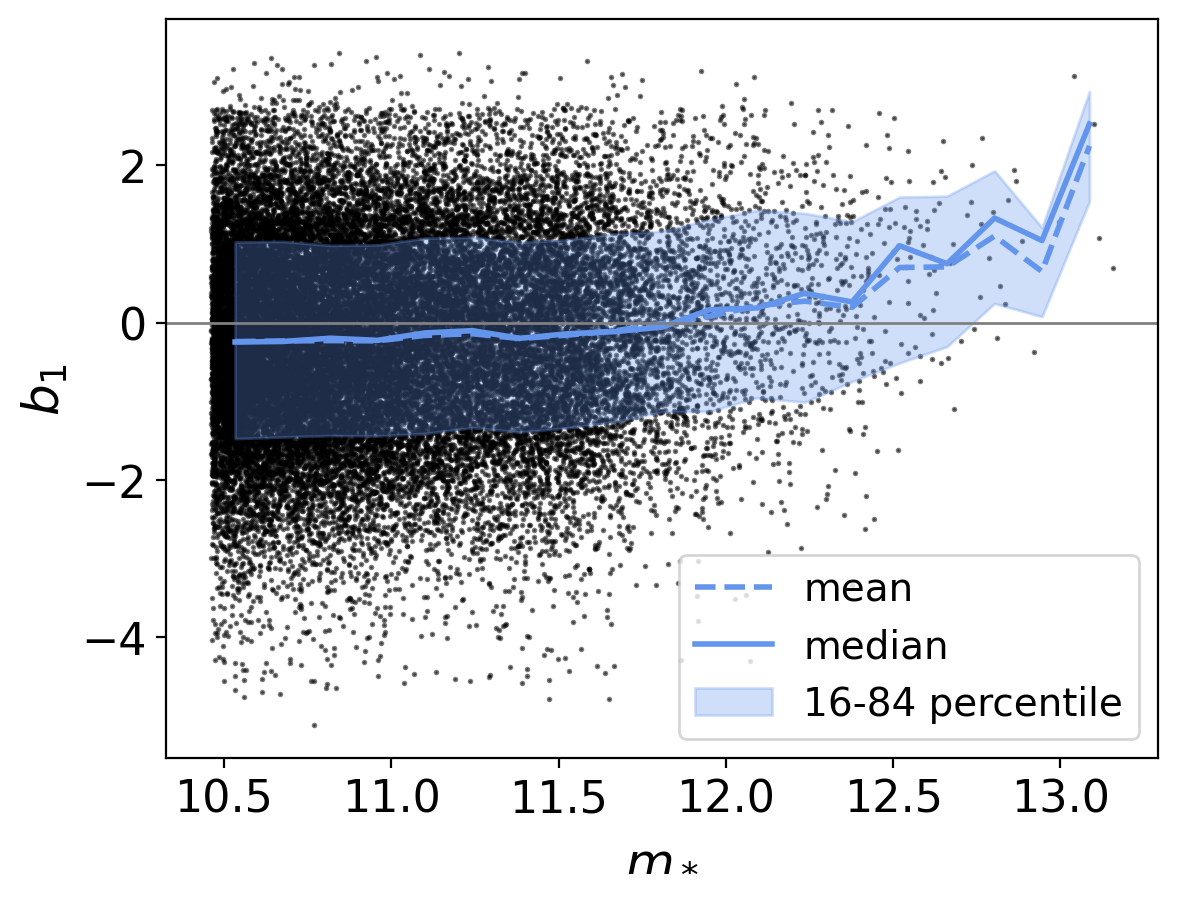

In [19]:
log_mstar_bins = np.linspace(np.min(log_mstar), np.max(log_mstar), 20)
log_mstar_bins_avg = 0.5*(log_mstar_bins[1:] + log_mstar_bins[:-1])

b1 = bias_per_object[:,0]
b1_binned = np.array([b1[(log_mstar > log_mstar_bins[i]) & (log_mstar < log_mstar_bins[i+1])] for i in range(len(log_mstar_bins)-1)])
i_hasdata = np.array([len(b1_bin) > 0 for b1_bin in b1_binned])
b1_binned = b1_binned[i_hasdata]
log_mstar_bins_avg = log_mstar_bins_avg[i_hasdata]

b1_mean = [np.mean(b1_bin) for b1_bin in b1_binned]
b1_median = [np.median(b1_bin) for b1_bin in b1_binned]
b1_16 = [np.percentile(b1_bin, 16) for b1_bin in b1_binned]
b1_84 = [np.percentile(b1_bin, 84) for b1_bin in b1_binned]

plt.scatter(log_mstar, b1, s=1, alpha=0.5, color='k')
plt.plot(log_mstar_bins_avg, b1_mean, color='cornflowerblue', lw=2, ls='--', label='mean')
plt.plot(log_mstar_bins_avg, b1_median, color='cornflowerblue', lw=2, label='median')

plt.fill_between(log_mstar_bins_avg, b1_16, b1_84, color='cornflowerblue', alpha=0.3, label='16-84 percentile')

plt.axhline(0, color='grey', lw=1)
plt.legend()
plt.xlabel(r'$m_*$')
plt.ylabel(r'$b_1$')

/tmp/ipykernel_391008/3254722994.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  b1_binned = np.array([b1[(log_mhalo > log_mhalo_bins[i]) & (log_mhalo < log_mhalo_bins[i+1])] for i in range(len(log_mhalo_bins)-1)])


Text(0, 0.5, '$b_1$')

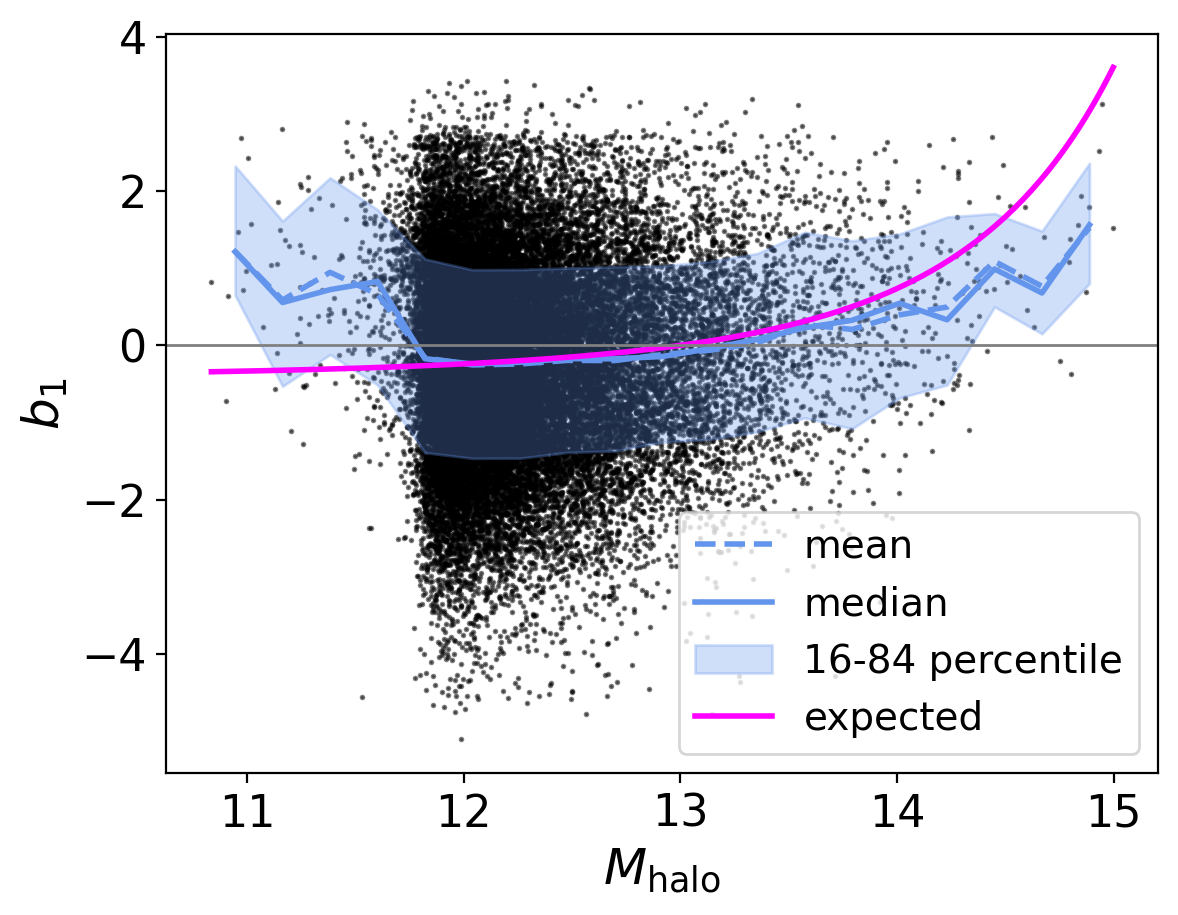

In [20]:
log_mhalo = log_mvir

# theory
log_mhalo_fine = np.linspace(np.min(log_mhalo), np.max(log_mhalo), 200)
mhalo_fine = 10**log_mhalo_fine
b1_mhalo_theory_eul = cosmo.compute_biasfunction(mass=mhalo_fine,
                        expfactor=1.0)
b1_mhalo_theory = b1_mhalo_theory_eul - 1

# plot
log_mhalo_bins = np.linspace(np.min(log_mhalo), np.max(log_mhalo), 20)
log_mhalo_bins_avg = 0.5*(log_mhalo_bins[1:] + log_mhalo_bins[:-1])

b1 = bias_per_object[:,0]
b1_binned = np.array([b1[(log_mhalo > log_mhalo_bins[i]) & (log_mhalo < log_mhalo_bins[i+1])] for i in range(len(log_mhalo_bins)-1)])
i_hasdata = np.array([len(b1_bin) > 0 for b1_bin in b1_binned])
b1_binned = b1_binned[i_hasdata]
log_mhalo_bins_avg = log_mhalo_bins_avg[i_hasdata]

b1_mean = [np.mean(b1_bin) for b1_bin in b1_binned]
b1_median = [np.median(b1_bin) for b1_bin in b1_binned]
b1_16 = [np.percentile(b1_bin, 16) for b1_bin in b1_binned]
b1_84 = [np.percentile(b1_bin, 84) for b1_bin in b1_binned]

plt.scatter(log_mhalo, b1, s=1, alpha=0.5, color='k')
plt.plot(log_mhalo_bins_avg, b1_mean, color='cornflowerblue', lw=2, ls='--', label='mean')
plt.plot(log_mhalo_bins_avg, b1_median, color='cornflowerblue', lw=2, label='median')

plt.fill_between(log_mhalo_bins_avg, b1_16, b1_84, color='cornflowerblue', alpha=0.3, label='16-84 percentile')

plt.plot(log_mhalo_fine, b1_mhalo_theory, color='magenta', lw=2, label='expected')

plt.axhline(0, color='grey', lw=1)
plt.legend()
plt.xlabel(r'$M_\mathrm{halo}$')
plt.ylabel(r'$b_1$')

#### Loop

In [21]:
n_threads_bacco = 8
ndens_target = 0.003
pb_arr = []
pb_cov_arr = []
log_mstar_arr = []
pos_arr_arr = []
for i in range(len(fn_arr)):
    fn_out = fn_arr[i]
    pos_arr_hMpc, vel_arr, log_mstar, log_mvir = load_tracer_data_lgalaxies(fn_out, ndens_target, box_size,
                                                                         cosmo.pars['hubble'],
                                                                         return_masses=True)
    id_arr = np.ones(len(pos_arr_hMpc), dtype=int)
    qdata = fpb.create_qdata_custom(sim, pos_arr_hMpc, vel_arr, id_arr, n_grid,
                                number_of_threads=n_threads_bacco)
    
    tracer_q = qdata['pos']
    b, bcov = pbm.fit_bias(model=model_expansion, tracer_q=tracer_q,
                            error="jack4")
    #bias_per_object = pbm.bias_model.bias_per_object(pbm.tr_value)
    pb_arr.append(b)
    pb_cov_arr.append(bcov)
    log_mstar_arr.append(log_mstar)
    pos_arr_arr.append(pos_arr_hMpc)
    
pb_arr = np.array(pb_arr)
pb_cov_arr = np.array(pb_cov_arr)
log_mstar_arr = np.array(log_mstar_arr)
pos_arr_arr = np.array(pos_arr_arr)

Total number of gals initially: 188263
qdata creation set up, finding lagrangian coordinates
nbodies 34072
chunk 0
0 4259
bacco.lss_scaler: Finding lagrangian positions for 4259 particles on a 128 grid with 512**3 parts
bacco.lss_scaler:  starting algorithm
scaler done
bacco.lss_scaler:  finished algorithm
chunk 1
4259 8518
scaler done
bacco.lss_scaler: Finding lagrangian positions for 4259 particles on a 128 grid with 512**3 parts
bacco.lss_scaler:  starting algorithmchunk 2
8518 12777

bacco.lss_scaler:  finished algorithm
scaler done
bacco.lss_scaler: Finding lagrangian positions for 4259 particles on a 128 grid with 512**3 parts
bacco.lss_scaler:  starting algorithm
bacco.lss_scaler:  finished algorithm
chunk 3
12777 17036
scaler done
bacco.lss_scaler: Finding lagrangian positions for 4259 particles on a 128 grid with 512**3 parts
bacco.lss_scaler:  starting algorithm
bacco.lss_scaler:  finished algorithm
chunk 4
17036 21295
scaler done
bacco.lss_scaler: Finding lagrangian position

In [22]:
b_arr = []
b_cov_arr = []
for i in range(pb_arr.shape[0]):
    bias_params, bias_param_names = utils.pbias_params_to_bias_params(dict(zip(terms, pb_arr[i])))
    b_arr.append(bias_params)
    bias_cov, bias_param_names = utils.pbias_params_to_bias_params(dict(zip(terms, pb_cov_arr[i])))
    b_cov_arr.append(bias_cov)
    
b_arr = np.array(b_arr)
b_cov_arr = np.array(b_cov_arr)

In [23]:
bias_param_names_nob1 = bias_param_names.copy()
bias_param_names_nob1.remove('b1')

Text(0.5, 0, '$b_1$')

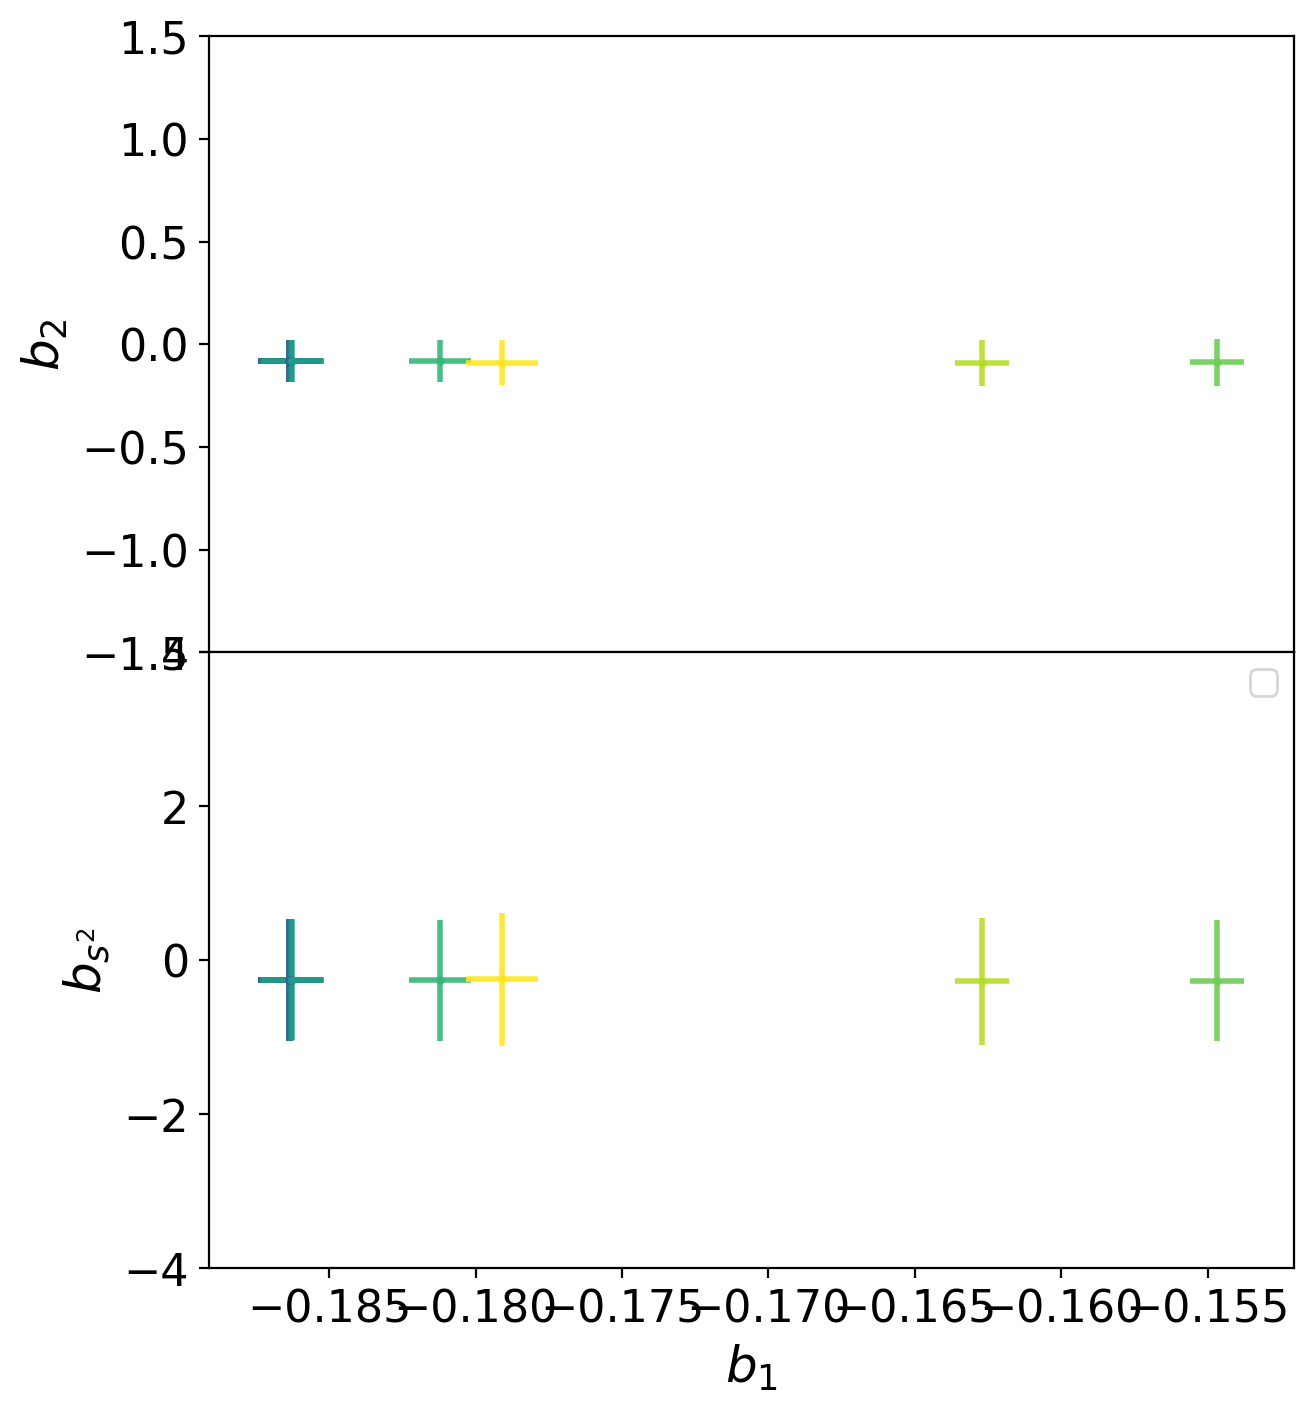

In [24]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(7, 4*nrows), sharex=True)
plt.subplots_adjust(hspace=0)

bp_arr = []
Asn_arr = []


bb_b1 = bias_param_names.index('b1')

for i in range(b_arr.shape[0]):

    for ib, bp_name in enumerate(bias_param_names_nob1):
        
        bb = bias_param_names.index(bp_name)
        
        bval = np.array(b_arr[i,bb])        
        axarr[ib].errorbar(b_arr[i,bb_b1], bval, 
                            yerr=b_cov_arr[i,bb,bb], 
                            xerr=b_cov_arr[i,bb_b1,bb_b1],
                            marker='o', markersize=2, color=colors[i], 
                            ls='None', alpha=0.9)

        axarr[ib].set_ylabel(utils.param_label_dict[bp_name])
    
    
handles, labels = plt.gca().get_legend_handles_labels()
# if color_mode=='discrete':
#     handles.extend(handles_discrete)
plt.legend(handles=handles, fontsize=12)
#plt.xlim(-2, 1)

axarr[0].set_ylim(-1.5, 1.5)
axarr[1].set_ylim(-4, 4)
#axarr[2].set_ylim(-10, 20)

plt.xlabel(utils.param_label_dict['b1'])

# if save_figs:
#     plt.savefig(f'{plot_dir}/bps{plot_tag}{tag_bpfit}.png')